In [269]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import pandas as pd
#import librosa
import logging
import os
from scipy.io import wavfile

#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# Configure the logging settings
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
if len(physical_devices) > 0:
    # Ensure TensorFlow uses the first GPU
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    #with tf.device('/GPU:0'):
else:
    print("No GPU devices found.")

In [171]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def audio_to_spectrogram(audio_file_path, max_length=6*22500, sr=22500):
    # Load the audio file with a specified duration
    y, sr = librosa.load(audio_file_path, sr=sr, duration=max_length)
    # Calculate the duration of the loaded audio
    audio_duration = librosa.get_duration(y=y, sr=sr)

    # Calculate the required amount of padding
    pad_length = max_length - int(audio_duration * sr)
    print(y.shape)
    print(audio_duration)
    print(pad_length)

    if pad_length > 0:
        # Pad the audio with zeros to match the maximum length
        y = np.pad(y, (0, pad_length), mode='constant')
    
    print(y.shape)
    # Calculate the STFT
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    return D

In [86]:
# Generator function for lazy loading of audio data
def audio_data_generator(audio_files):
    for audio_file in audio_files:
        yield audio_to_spectrogram(audio_file)

# Load a list of audio files
audio_files_df = pd.read_csv('data_files_summary.csv')
audio_files = audio_files_df['full_path'].to_list()

In [89]:
%%time
# Create a generator to load and preprocess audio data on-the-fly
data_generator = audio_data_generator(audio_files[:3000])
data_iterator = iter(data_generator)  # Convert the generator to an iterator

# To train an autoencoder, you need target data, which is the same as the input data
# So, use the same data for both input and target
X_train = np.array(list(data_iterator))#.reshape(6300, 1025, 308, 1)
X_train.shape

CPU times: total: 19.5 s
Wall time: 19.5 s


(2000, 1025, 308)

In [91]:
X_train = X_train.reshape(3000, 1025, 308, 1)

In [114]:
X_train_scaled = ((X_train + 80)/80)

In [268]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Normalization, Reshape, Dense, Flatten, Cropping2D
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (1025, 308, 1)  # You can adjust the input shape based on your data

# Define the encoder
input_layer = Input(shape=input_shape)
x = input_layer

x = Conv2D(128, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Cropping2D(cropping=((3, 0), (0, 0)))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded)

# Compile the autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
autoencoder.compile(optimizer='adam', loss='mse')
# Print the model summary
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1025, 308, 1)]    0         
                                                                 
 conv2d_40 (Conv2D)          (None, 1025, 308, 128)    1280      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 513, 154, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 513, 154, 32)      36896     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 257, 77, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 257, 77, 32)       9248

In [117]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)
# Step 3: Train the autoencoder using audio data
logging.info('Training the autoencoder...')
autoencoder.fit(X_train_scaled, X_train_scaled, batch_size=32, epochs=300, callbacks=[early_stopping])
logging.info('Training complete.')

2023-10-19 23:46:33,879 - root - INFO - Training the autoencoder...


Epoch 1/300
63/63 [==============================] - 386s 6s/step - loss: 0.0461
Epoch 2/300
63/63 [==============================] - 382s 6s/step - loss: 0.0281
Epoch 3/300
57/63 [==========================>...] - ETA: 35s - loss: 0.0059

KeyboardInterrupt: 

In [264]:
import soundfile as sf  # Soundfile library for saving the WAV file
def spectrogram_to_audio(spectrogram, sr=22500, max_length=112500):
    # Inverse operation to recover the magnitude spectrum
    magnitude = librosa.db_to_amplitude(D)#, ref=np.max)
    
    # Inverse Short-Time Fourier Transform (iSTFT) to obtain the time-domain signal
    y_reconstructed = librosa.istft(magnitude)

    return y_reconstructed

# Example usage
spectrogram = audio_to_spectrogram("converted.wav", sr=48000)[:, :-5].reshape((1, 1025, 308, 1))
spectrogram = (spectrogram+80)/80
out_spectre = autoencoder.predict(spectrogram)
out_spectre = (out_spectre*80)-80
out_spectre = out_spectre.reshape((1025, 308))
reconstructed_audio = spectrogram_to_audio(out_spectre, 22500) * 1e3
sf.write("reconstructed_audio.wav", np.ravel(reconstructed_audio), 22500)  # Adjust the sample rate as needed


(159744,)
3.328
-24744
(159744,)
1/1 [==============================] - 0s 50ms/step


In [267]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1025, 308, 1)]    0         
                                                                 
 conv2d_35 (Conv2D)          (None, 1025, 308, 16)     160       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 513, 154, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 513, 154, 8)       1160      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 257, 77, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 257, 77, 8)        584 

In [260]:
y, sr = librosa.load('converted.wav', sr=22500, duration=112500)


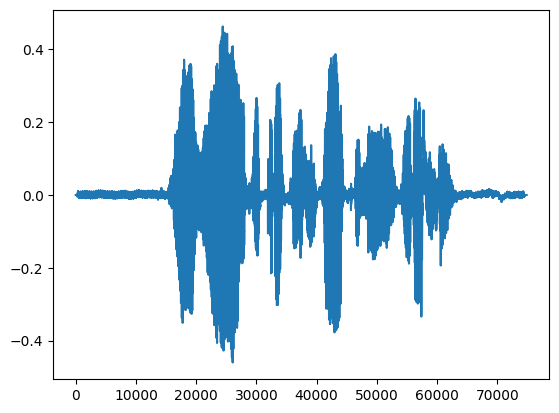

In [265]:
plt.plot(y)

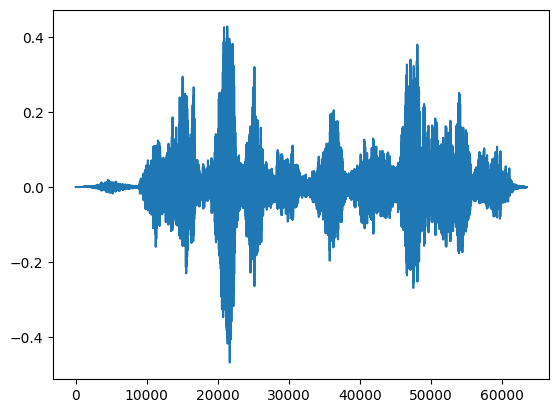

In [266]:
plt.plot(reconstructed_audio)

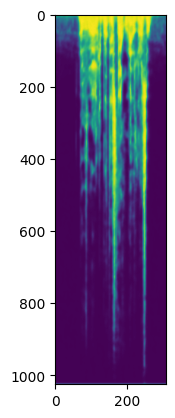

In [223]:
plt.imshow(out_spectre)

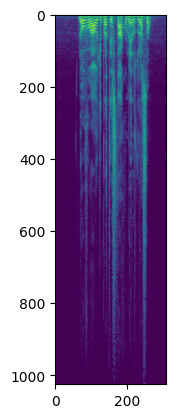

In [224]:
plt.imshow(spectrogram[0])